# Week 2 Notebook

### <a href='#init'>Initialisation</a> 

### <a href='#xgb_base'> Train Baseline XGBoost Model</a>

<a href='#xgb_base'> 1a. Baseline model resampling with SMOTE </a>

<a href='#xgb_base_spw'> 1b. Baseline model resampling with scale_pos_weight (BEST) </a>

<a href='#xgb_base_rz'> 1c. Baseline model replace negatives </a>

### <a href='#xgb_feat'> Introduce New Features</a>

### <a href='#xgb_hpr'> Hyper Parameter Tuning</a>

## Initialisation <a id='init'></a>

In [1]:
# import packages
import pandas as pd
import numpy as np

# set working directory
import os
os.chdir('/home/jovyan/work/')

## Train Baseline XGBoost Models <a href='xgb_base'></a>
#### 1a. Baseline model with SMOTE

In [2]:
from src.data.load_dataset import load_split_store
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()

# load_split_store contains resample input, 
    # True: SMOTE
X_train, y_train, X_val, y_val, X_test, y_test, test_data = load_split_store(
                                                                    filepath='data/', 
                                                                    scaler=scaler, resample=True, 
                                                                    random_state=42, 
                                                                    test_size=0.15, 
                                                                    replace_negatives=False)

Balance of positive and negative classes (%):
1    50.0
0    50.0
Name: TARGET_5Yrs, dtype: float64


In [3]:
import xgboost as xgb

model_base_sm = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc').fit(X_train, y_train)

-----------
Confusion Matrix with thresthold of 0.5:


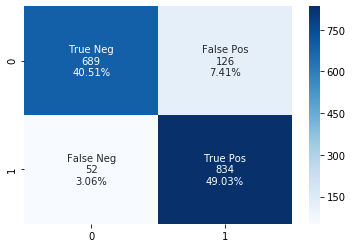

960 out of 1701 or 56% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9413
Accuracy: 0.8954
F1: 0.9036
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.945


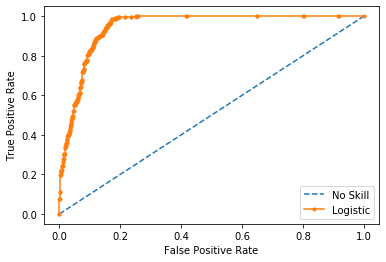

In [4]:
from src.visualization.visualize import eval_metrics

# predict validation set
y_val_pred = model_base_sm.predict_proba(X_val)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.5)

#### 1b. Baseline Model with xgboost built-in sampling method <a id='xgb_base_spw'></a>

In [5]:
# load_split_store contains resample input, 
    # True: resample with SMOTE
X_train, y_train, X_val, y_val, X_test, y_test, test_data = load_split_store(
                                                                    filepath='data/', 
                                                                    scaler=scaler, 
                                                                    resample=False, 
                                                                    random_state=42, 
                                                                    test_size=0.15, 
                                                                    replace_negatives=False)

Calculate positive weighting in training label

In [6]:
pos_count = sum(y_train)
neg_count = y_train.count() - pos_count
pos_weight = neg_count / pos_count
pos_weight

0.19966791199667913

In [7]:
import xgboost as xgb

model_base = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc', scale_pos_weight=pos_weight).fit(X_train, y_train)

-----------
Confusion Matrix with thresthold of 0.5:


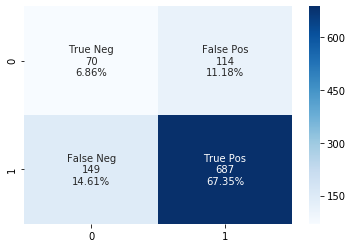

801 out of 1020 or 79% of players are predicted to be 5+ Yrs
-----------
Recall: 0.8218
Accuracy: 0.7422
F1: 0.8393
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.671


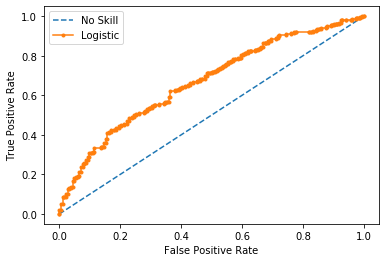

In [8]:
from src.visualization.visualize import eval_metrics

# predict validation set
y_val_pred = model_base.predict_proba(X_val)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.5)

### 1c. Base Model with negatives replaced in data <a id='xgb_base_rz'></a>

In [10]:
# load_split_store contains resample input True: resample with SMOTE
                            # test_size 0.15
X_train, y_train, X_val, y_val, X_test, y_test, test_data = load_split_store(
                                                                    filepath='data/', 
                                                                    scaler=scaler, 
                                                                    resample=False, 
                                                                    random_state=42, 
                                                                    test_size=0.15, 
                                                                    replace_negatives=True)

In [11]:
model_base = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc', scale_pos_weight=pos_weight).fit(X_train, y_train)

-----------
Confusion Matrix with thresthold of 0.5:


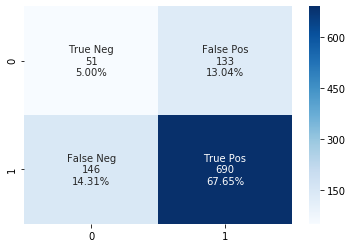

823 out of 1020 or 81% of players are predicted to be 5+ Yrs
-----------
Recall: 0.8254
Accuracy: 0.7265
F1: 0.8318
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.629


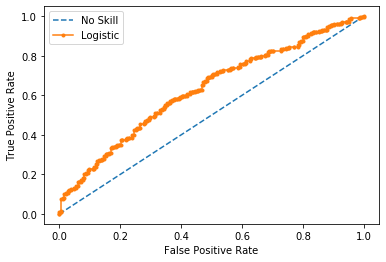

In [12]:
from src.visualization.visualize import eval_metrics

# predict validation set
y_val_pred = model_base.predict_proba(X_val)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.5)

## Introduce New Features <a id='xgb_feat'></a>

In [41]:
# Load data with resampling, but not replacing negatives
X_train, y_train, X_val, y_val, X_test, y_test, test_data = load_split_store(
                                                                    filepath='data/', 
                                                                    scaler=scaler, 
                                                                    resample=False, 
                                                                    random_state=42, 
                                                                    test_size=0.15, 
                                                                    replace_negatives=False)

In [60]:
from src.features.build_features import add_features_min_average
import xgboost as xgb

# add new features
X_train_feat = add_features_min_average(X_train)
X_val_feat = add_features_min_average(X_val)
X_test_feat = add_features_min_average(X_test)
X_train_feat.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,...,STL,BLK,TOV,PTS_pm,FTM_pm,REB_pm,AST_pm,STL_pm,BLK_pm,TOV_pm
7629,-0.337723,-0.769658,-1.034416,-0.949075,-0.957280,-0.310135,-1.039119,-0.860435,0.918115,-1.179712,...,-0.855464,-0.504872,-1.186024,1.343996,1.532775,1.212210,0.598433,1.111486,0.655969,1.540976
6200,-0.746783,0.976343,0.980190,0.822648,1.246755,-1.252448,0.262882,0.518697,0.698967,1.735756,...,1.352580,0.459698,1.302827,1.003940,1.777814,0.321609,0.510254,1.385353,0.470836,1.334395
1201,-0.863658,-0.959927,-0.316568,-0.299443,-0.148204,-1.089980,-0.713619,-0.630579,1.431745,-0.531830,...,0.125889,-0.183349,-0.771215,0.329784,0.554032,0.672156,0.787138,-0.131145,0.191003,0.803411
3219,0.889458,1.166612,0.169716,0.468303,0.102889,1.899427,-1.039119,-1.090290,-1.396642,0.008072,...,0.616566,2.549599,-0.079868,0.145478,0.006919,3.064732,0.110941,0.528509,2.185472,-0.068461
4320,-1.448029,0.069766,-0.223943,-0.299443,-0.622490,1.915673,-1.039119,-1.090290,-1.396642,1.411815,...,-0.364787,0.298936,0.334941,-3.209915,20.236475,42.998404,-15.058967,-5.228734,4.284848,4.800923


In [61]:
model_feat = xgb.XGBClassifier(objective='binary:logistic', 
                               use_label_encoder=False, 
                               eval_metric='auc', 
                               scale_pos_weight=pos_weight,
                               max_depth=13).fit(X_train_feat, y_train)

-----------
Confusion Matrix with thresthold of 0.5:


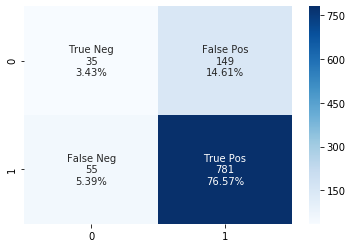

930 out of 1020 or 91% of players are predicted to be 5+ Yrs
-----------
Recall: 0.9342
Accuracy: 0.8
F1: 0.8845
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.620


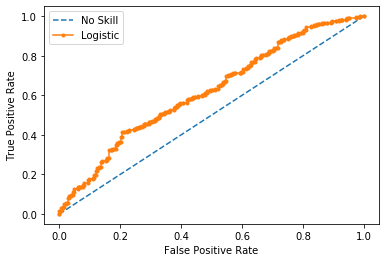

In [62]:
from src.visualization.visualize import eval_metrics

# predict validation set
y_val_pred = model_feat.predict_proba(X_val_feat)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.5)

## Train XGBoost with Hyperot <a id='xgb_hpr'></a>

#### Execute manual hyper parameter experiments to identify feature range

In [63]:
from src.visualization.visualize import eval_metrics
from sklearn.metrics import roc_auc_score

num_boost_round = 999

xgb_exp = xgb.XGBClassifier(
    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
    gamma = 0.6,
    reg_lambda = 0.6,
    scale_pos_weight=pos_weight,
    min_child_weight = 1, # range 30 - 40
    learning_rate = 0.1, # range 0.01 - 0.20
    n_estimators = 13, # range 5 - 15
    reg_alpha = 0.9, # range 0.7 - 0.9, 0.05
    max_depth = 4, # range 1-5
    subsample = 0.3, # range 0.25 - 0.4
    colsample_bytree = 0.95, # range 0.5 - 1, 0.05
).fit(X_train_feat, y_train)

# predict validation set
y_val_pred = xgb_exp.predict_proba(X_val_feat)[:, 1]
roc_auc_score(y_val, y_val_pred)
# print evaluation metrics


0.6753887559808612

In [64]:
import xgboost as xgb
from src.visualization.visualize import eval_metrics
from hpsklearn import HyperoptEstimator, sgd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

space = {
    'max_depth' : hp.choice('max_depth', range(2, 20, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.3, 0.01),
    'min_child_weight' : hp.quniform('min_child_weight', 5, 30, 1),
    'subsample' : hp.quniform('subsample', 0.25, 0.4, 0.05)
}

In [65]:
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = xgb.XGBClassifier(
        objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=pos_weight,
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample']
    )
    
    auc = cross_val_score(xgboost, X_train_feat, y_train, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-auc, 'status': STATUS_OK }

In [67]:
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=10
)

100%|██████████| 10/10 [00:25<00:00,  2.54s/trial, best loss: 0.3021154192995106]


In [68]:
print("Best:", best)

Best: {'learning_rate': 0.02, 'max_depth': 10, 'min_child_weight': 18.0, 'subsample': 0.35000000000000003}


In [69]:
xgb_hpr = xgb.XGBClassifier(
    objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
    scale_pos_weight=pos_weight,
    gamma = 0.6,
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample']
).fit(X_train, y_train)

-----------
Confusion Matrix with thresthold of 0.4:


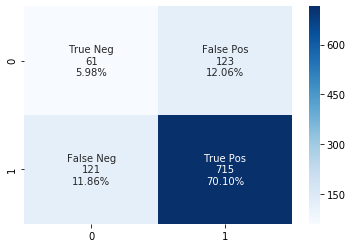

838 out of 1020 or 82% of players are predicted to be 5+ Yrs
-----------
Recall: 0.8553
Accuracy: 0.7608
F1: 0.8542
-----------
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.688


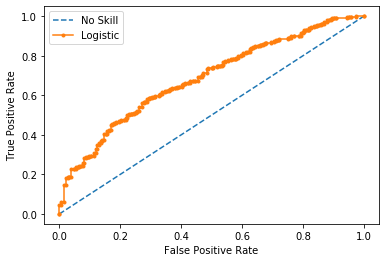

In [85]:
from src.visualization.visualize import eval_metrics

# predict validation set
y_val_pred = xgb_hpr.predict_proba(X_val)[:, 1]

# print evaluation metrics
eval_metrics(y_val_pred, y_val, praba_threshold=0.40)

In [71]:
from src.models.predict_model import model_submission

# this model obtain score 0.70696
model_submission(xgb_hpr, test_data, modelname='david_0214_xgb_hyperopt.joblib', submissionname='0214_xgb_hyperopt2')

In [81]:
import operator
feat_imp_sorted = sorted(feat_imp.items(), key=operator.itemgetter(1), reverse=True)
feat_imp_sorted

[('GP', 15.390823848054549),
 ('PTS', 10.860258016666668),
 ('FTA', 9.244285538181817),
 ('OREB', 7.7757326800000035),
 ('FGM', 7.22568727),
 ('FG%', 6.5416351886249995),
 ('FTM', 5.886401314),
 ('REB', 5.286280327499999),
 ('BLK', 5.027479629999999),
 ('FT%', 4.509775689285715),
 ('TOV', 4.156002582500001),
 ('AST', 3.7962280784615383),
 ('REB_pm', 3.7731969800000003),
 ('FTM_pm', 3.7310314791304346),
 ('3PA', 3.728945629214285),
 ('STL_pm', 3.656743489727272),
 ('MIN', 3.585761018444444),
 ('STL', 3.554648243333333),
 ('3P%', 3.547304146206897),
 ('AST_pm', 3.2608671399999993),
 ('FGA', 3.2436557425),
 ('TOV_pm', 3.1858047366666664),
 ('PTS_pm', 3.0656664620689655),
 ('BLK_pm', 2.918376337954545),
 ('DREB', 2.911172337444445),
 ('3P Made', 2.55386003)]

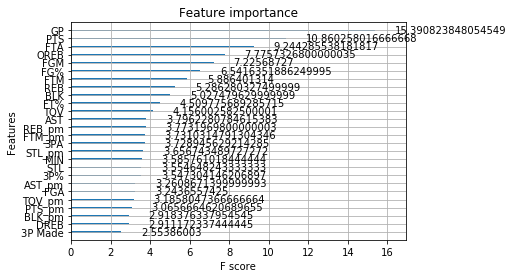

In [74]:
feat_imp = xgb_hpr.get_booster().get_score(importance_type="gain")
xgb.plot_importance(feat_imp)

In [32]:
from sklearn.inspection import permutation_importance

r = permutation_importance(
    xgboost2, X_train, y_train,
    n_repeats=30,
    random_state=8
)

In [33]:
for i in r.importances_mean.argsort()[::-1]:
     print(f"{X_train.columns[i]}: {r.importances_mean[i]:.5f}")

GP: 0.01053
FG%: 0.01025
3PA: 0.00142
BLK_pm: 0.00107
AST_pm: 0.00078
FTM_pm: 0.00072
DREB: 0.00055
FGA: 0.00048
STL_pm: 0.00046
OREB: 0.00037
3P Made: 0.00027
BLK: 0.00022
MIN: 0.00016
TOV: 0.00005
AST: -0.00002
PTS: -0.00006
PTS_pm: -0.00016
3P%: -0.00027
FGM: -0.00032
FT%: -0.00047
TOV_pm: -0.00115
STL: -0.00157
REB: -0.00225
REB_pm: -0.00390
FTM: -0.00392
FTA: -0.00666
